# ML Algorithms for Breast Cancer Identification
#### Sara Díaz del Ser

### Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
import numpy as np
import plotly.express as px

# Int cufflinks
# making all charts public and setting a global theme
cf.set_config_file(theme='solar',offline=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set matplotlib in Darkmode
plt.style.use('dark_background')

### 01. Load the Dataset

In [3]:
def load_dataset(path:str) -> pd:
    return pd.read_csv(path)

In [4]:
# Loading data using pandas
path = 'Breast Cancer.csv'
dataset = load_dataset(path)

### 02. Explore the Dataset

In [5]:
# Explore the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 58.8 KB


In [6]:
# Check if there are missing values
# This shows if any columns have NA or NAN
dataset.isna().any()

Sample code number             False
Clump Thickness                False
Uniformity of Cell Size        False
Uniformity of Cell Shape       False
Marginal Adhesion              False
Single Epithelial Cell Size    False
Bare Nuclei                    False
Bland Chromatin                False
Normal Nucleoli                False
Mitoses                        False
Class                          False
dtype: bool

In [7]:
#Plotting data
def plot_data(dataset):
    """Plot out all the data from the dataset in different histograms"""
    dataset.hist(bins=50, figsize = (20,15))
    plt.show()
    return


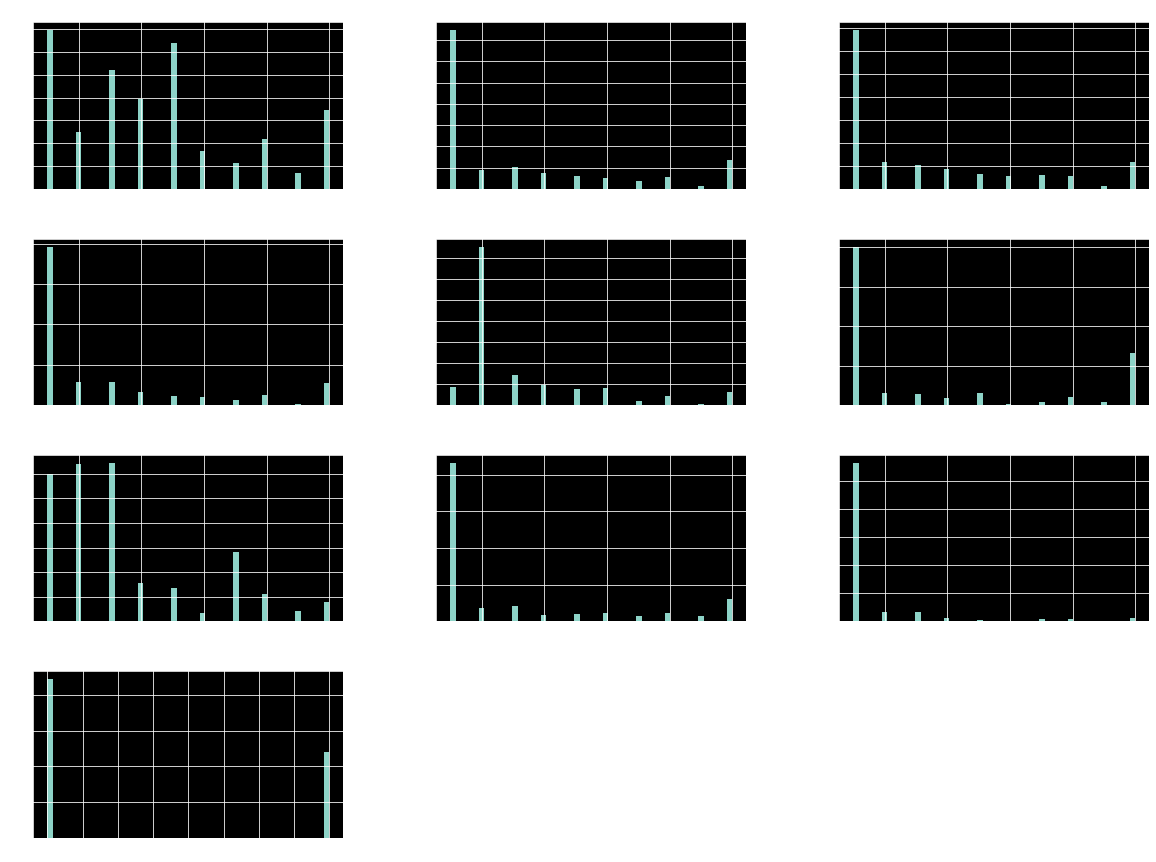

In [8]:
# Remove sample code number because that is not a feature
dataset = dataset.drop('Sample code number', axis=1)
plot_data(dataset)


### 03. Correlation Matrix

In [9]:
def correlation_heatmap(corr):
    """Plot feature correlation heatmap"""
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), annot = True,
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    return

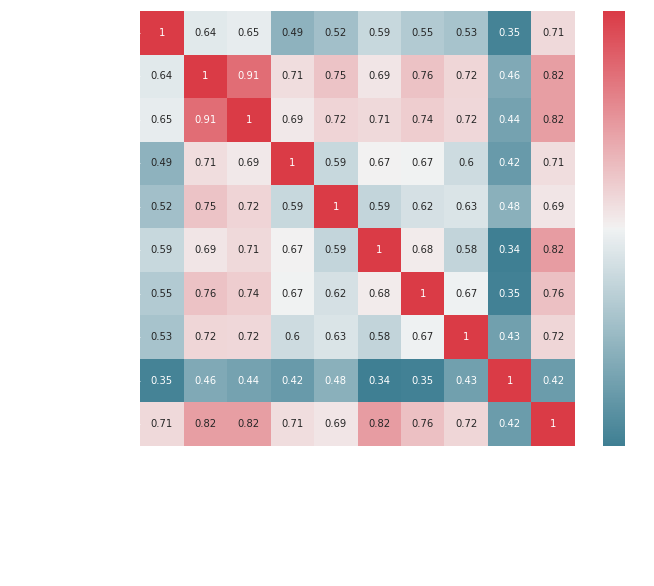

In [10]:
# Correlation data
corr = dataset.corr()

# Correlation matrix
correlation_heatmap(corr)


There is very high correlation between 'Uniformity of Cell shape' and 'Uniformity of Cell Size'.

It's worth noting 'Class' has correlation with quite a few features, the most relevant being:
Bare Nuclei (0.82), Uniformity of Cell Size (0.82) and Uniformity of Cell Shape (0.82)

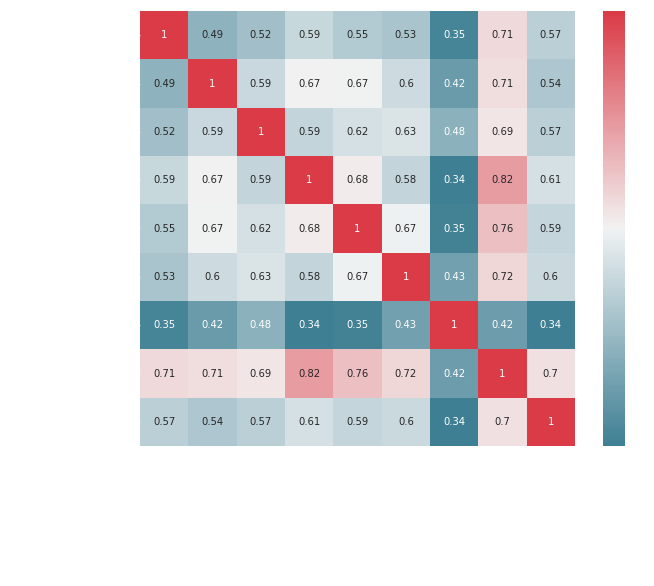

In [11]:
# Try Feature Engineering

dataset['UCSh/UCSi Ratio'] = dataset['Uniformity of Cell Shape'] / np.sqrt(dataset['Uniformity of Cell Size'])
corr2 = dataset.drop(['Uniformity of Cell Shape', 'Uniformity of Cell Size'], axis=1).corr()

# Correlation data if we drop some rows
# corr2 = dataset.drop('Uniformity of Cell Shape', axis=1).corr()

# Correlation matrix
correlation_heatmap(corr2)

In order to reduce the high correlation between the two features, there are various possibilities.

One of the options would be to drop one of the highly correlated features. This option, albeit simple, is less than desireble
since there are only a few features, and this would mean losing valueable information.

Another option would be feature engineering, which is what was chosen in this case:
A new engineered feature 'UCSh/UCSi Ratio' was created from UCSh/sqrt(UCSi). Then, the correlated features were removed
and a better correlation matrix was generated.

In [12]:
dataset = dataset.drop(['Uniformity of Cell Shape', 'Uniformity of Cell Size'], axis=1)

### Functions for Checking Parameters

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Check AOC ARC curve
def aoc_arc_curve(pred, labels_test):
    """Plots the AOC ARC curve and score"""
    auc_score = roc_auc_score(labels_test, pred)
    print('AUROC score: {:.2f}'.format(auc_score))

    false_positive_rate, true_positive_rate, thresholds = roc_curve(labels_test, pred, pos_label=4)

    plt.figure(figsize=(5, 4), dpi=100)
    plt.axis('scaled')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("AUC & ROC Curve")
    plt.plot(false_positive_rate, true_positive_rate, 'g')

    plt.plot([0,1],[0,1], color='blue', linestyle='dotted')

    plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
    plt.text(0.95, 0.05, 'AUC = {:.2f}'.format(auc_score), ha='right', fontsize=12, weight='bold')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()
    
    return auc_score

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def parameter_check(pred, labels_test):
    """Determines accuracy, precision, recall, f1 and aoc arc curve"""
    # Check accuracy
    accuracy = accuracy_score(labels_test , pred)

    # Check precision
    precision = precision_score(labels_test , pred, pos_label=4)
    # Check recall
    recall = recall_score(labels_test , pred, pos_label=4)
    # Check F1 score
    F1 = f1_score( labels_test , pred, pos_label=4)
    print('Accuracy: {:.2f}'.format(accuracy))
    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('F1 score: {:.2f}'.format(F1))
    
    auc = aoc_arc_curve(pred, labels_test)
    
    return { 'accuracy': accuracy, 'precision':precision, 'recall':recall, 'fi':F1, 'auc': auc}


### 04 Data Pre-processing

In [15]:
from sklearn.model_selection import train_test_split

# Create features and labels
features = dataset.drop(['Class'], axis=1)

labels = dataset['Class']

# Create training (75%) and test (25%) sets
features_train, features_test , labels_train , labels_test = train_test_split(features, labels,
                                                                              random_state=42, test_size =0.25)

# Feature Selection

### Feature Importance Plot

In [16]:
def feature_importance(classifier, features_train, labels_train):
    """Plot feature importance"""
    classifier.fit(features_train, labels_train)

    # Creating a new data frame
    feature_importance = pd.DataFrame()
    feature_importance['Features'] =  list(features_train.columns)
    feature_importance['Importance'] = list(classifier.coef_[0]) # values in dataframe
    feature_importance.sort_values(by=['Importance'], ascending=True, inplace=True)
    feature_importance['positive'] = feature_importance['Importance'] > 0 # ranking of feat.
    feature_importance.set_index('Features', inplace=True) # Set the DataFrame index

        # Creating plot of feature importance
    feature_importance.Importance.plot(kind='barh', figsize=(11, 6),color =
        feature_importance.positive.map({True: 'blue', False: 'red'}))

    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Feature contribution to breast cancer')
    plt.show()


According to the literature [1], the relevant features are:
- Uniformity of cell size
- Single epithelial cell size
- Bland chromatin
- Normal nucleoli


### 05 Classifier

In [17]:
def run_classifier(classifier, features_train, labels_train, features_test, labels_test) -> dict:
    # Fit data for training into classifier
    classifier.fit(features_train , labels_train)
    # Predicting with classifier
    pred = classifier.predict(features_test)
    return parameter_check(pred, labels_test)

##  Pipeline

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

In [19]:
def build_pipeline(params, classifier, rskf=False):
    # Setting up a pipeline
    pipe = Pipeline([
        ('scaler', None),
        ('imputer', None),
        ('balancing', None),
        ('clf', classifier)
    ])

    # Cross validation
    if rskf:
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    else:
        cv = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)

    # Set up the grid search
    gs = GridSearchCV(pipe,params,n_jobs=-1,cv=cv,scoring='accuracy')

    # Fit gs to training data
    gs_results = gs.fit(features_train, labels_train)

    # Find best fit
    print(f'Best score: {gs_results.best_score_}')
    print(f'Best parameters: \n{gs_results.best_params_}')

    # Get score
    print(f'\nScore: {gs.score(features_test, labels_test)}')

    # Predict results
    labels_preds = gs.predict(features_test)
    best_par = parameter_check(labels_preds, labels_test)

    return best_par, gs_results


### KNN Classifier - Pipeline

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.impute import SimpleImputer

# Create KNN Classifier
classifier_knn = KNeighborsClassifier()

# Parameter grid to search over using grid search
params={
    'imputer': [SimpleImputer(missing_values=0)],
    'imputer__strategy': ['mean', 'median'],
    'balancing': ['passthrough',
                  RandomOverSampler(random_state=42),
                  SMOTENC(categorical_features=[0], random_state=42, k_neighbors=0),
                  RandomUnderSampler(random_state=42),
                  TomekLinks()
                  ],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'clf__n_neighbors':[3,5,7,9,11,13],
    'clf__weights':['uniform', 'distance'],
    'clf__metric': ['minkowski', 'manhattan', 'euclidian']
}

Best score: 0.9687797449076718
Best parameters: 
{'balancing': 'passthrough', 'clf__metric': 'manhattan', 'clf__n_neighbors': 5, 'clf__weights': 'uniform', 'imputer': SimpleImputer(missing_values=0), 'imputer__strategy': 'mean', 'scaler': StandardScaler()}

Score: 0.9473684210526315
Accuracy: 0.95
Precision: 0.98
Recall: 0.88
F1 score: 0.93
AUROC score: 0.94


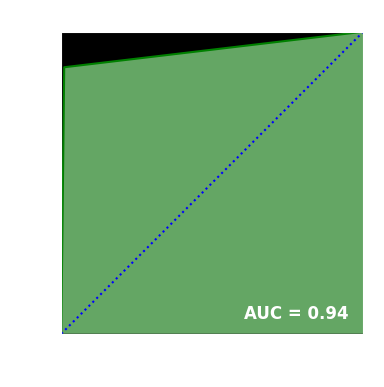

In [21]:
best_par_knn, score_knn = build_pipeline(params,classifier_knn)

### SVM Classifier - Pipeline

In [22]:
from sklearn.svm import SVC

# Create SVM Classifier
classifier_svm = SVC()

# Parameter grid to search over using grid search
params={
    'imputer': [SimpleImputer(missing_values=0)],
    'imputer__strategy': ['mean', 'median'],
    'balancing': ['passthrough',
                  RandomOverSampler(random_state=42),
                  SMOTENC(categorical_features=[0], random_state=42, k_neighbors=0),
                  RandomUnderSampler(random_state=42),
                  TomekLinks()
                  ],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'clf__degree':[0.001, 0.01, 0.1, 1, 10],
    'clf__gamma' : [1,2,3,4,5]
    #'clf__kernel' :['rbf', 'linear', 'poly' ,'sigmoid']
}

Best score: 0.9609366076527699
Best parameters: 
{'balancing': 'passthrough', 'clf__degree': 0.001, 'clf__gamma': 1, 'imputer': SimpleImputer(missing_values=0), 'imputer__strategy': 'mean', 'scaler': MinMaxScaler()}

Score: 0.9473684210526315
Accuracy: 0.95
Precision: 0.97
Recall: 0.90
F1 score: 0.93
AUROC score: 0.94


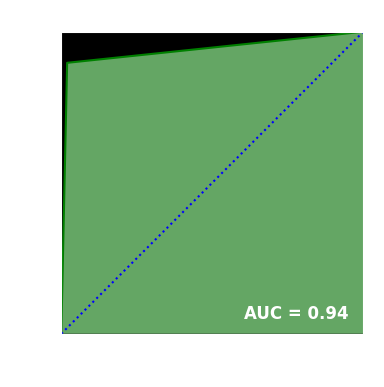

In [23]:
best_par_svm, score_svm = build_pipeline(params, classifier_svm)

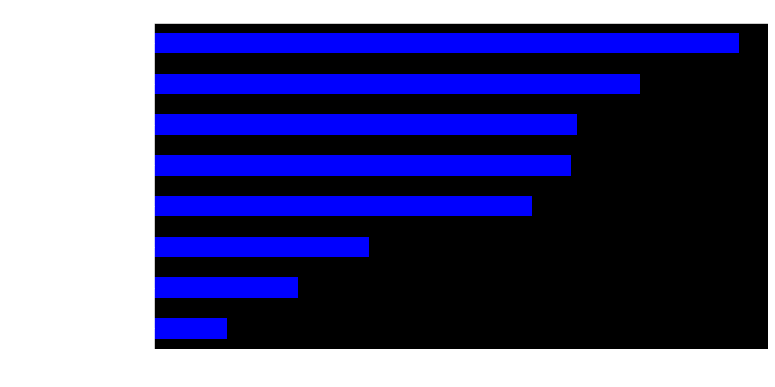

In [24]:
feature_importance(SVC(kernel='linear'), features_train, labels_train)

### Logistic Regression - Pipeline

In [25]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression Classifier
classifier_lr = LogisticRegression()

# Parameter grid to search over using grid search
params={
    'imputer': [SimpleImputer(missing_values=0)],
    'imputer__strategy': ['mean', 'median'],
    'balancing': ['passthrough',
                  RandomOverSampler(random_state=42),
                  SMOTENC(categorical_features=[0], random_state=42, k_neighbors=0),
                  RandomUnderSampler(random_state=42),
                  TomekLinks()
                  ],
    'scaler':[StandardScaler(), MinMaxScaler()],
    'clf__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'clf__multi_class':['ovr', 'multinomial'],
    'clf__class_weight':['None', 'balanced']
}

Best score: 0.9707405292213973
Best parameters: 
{'balancing': 'passthrough', 'clf__class_weight': 'balanced', 'clf__multi_class': 'ovr', 'clf__solver': 'newton-cg', 'imputer': SimpleImputer(missing_values=0), 'imputer__strategy': 'mean', 'scaler': StandardScaler()}

Score: 0.9590643274853801
Accuracy: 0.96
Precision: 0.98
Recall: 0.91
F1 score: 0.95
AUROC score: 0.95


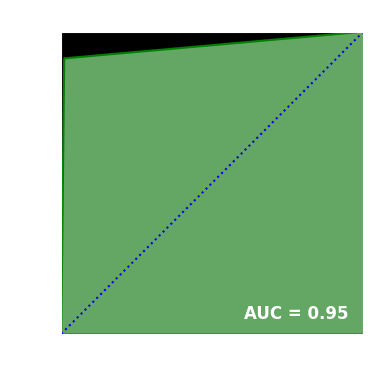

In [26]:
best_par_lr, score_lr = build_pipeline(params, classifier_lr)

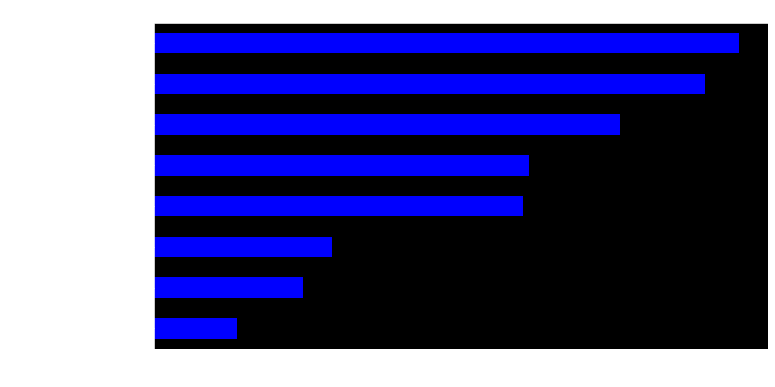

In [27]:
feature_importance(classifier_lr, features_train, labels_train)

### Random Forest Classifier - Pipeline

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest Classifier
classifier_rf = RandomForestClassifier(criterion='entropy')

# Parameter grid to search over using grid search
params={
    'clf__n_estimators':[10, 50, 100, 500],
    'clf__max_depth': [20,30,50],
    'clf__min_samples_split': [2,3,4],
    'clf__min_samples_leaf': [3,5]
}

Best score: 0.9707214924804873
Best parameters: 
{'clf__max_depth': 30, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

Score: 0.9532163742690059
Accuracy: 0.95
Precision: 0.98
Recall: 0.90
F1 score: 0.94
AUROC score: 0.94


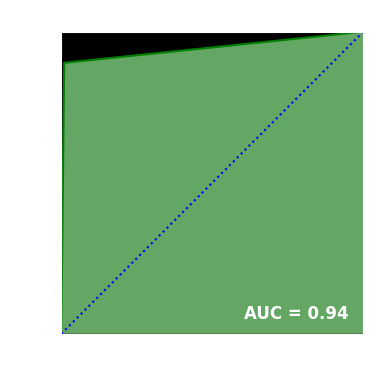

In [29]:
best_par_rf, score_rf = build_pipeline(params, classifier_rf)

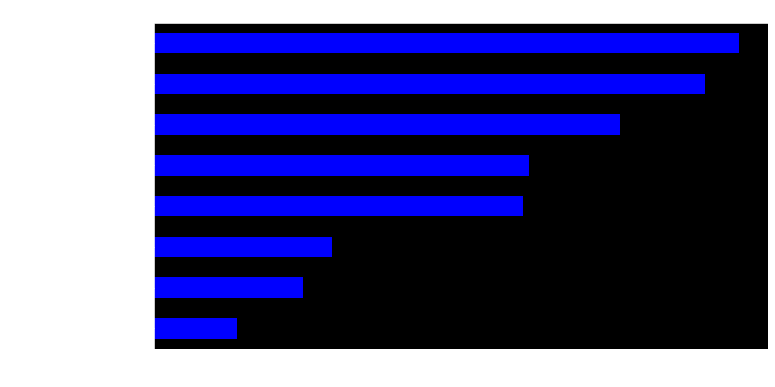

In [30]:
feature_importance(LogisticRegression(), features_train, labels_train)

### AdaBoost Classifier - Pipeline

In [31]:
from sklearn.ensemble import AdaBoostClassifier

# Create AdaBoost Classifier
classifier_ada = AdaBoostClassifier()

# Parameter grid to search over using grid search
params={
    'clf__n_estimators':[10, 50, 100, 500],
    'clf__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

Best score: 0.9648391395393109
Best parameters: 
{'clf__learning_rate': 0.1, 'clf__n_estimators': 50}

Score: 0.9473684210526315
Accuracy: 0.95
Precision: 0.98
Recall: 0.88
F1 score: 0.93
AUROC score: 0.94


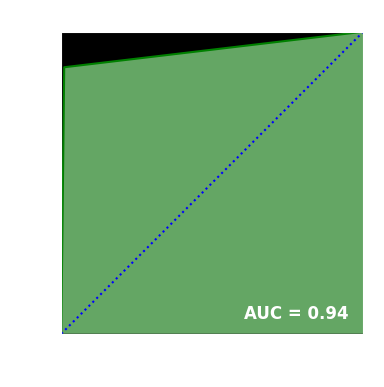

In [32]:
best_par_ada, score_ada = build_pipeline(params, classifier_ada, rskf=True)


### GradientBoost Classifier - Pipeline

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

# Create GradientBoost Classifier
classifier_grad = GradientBoostingClassifier()

# Parameter grid to search over using grid search
params={
    'clf__n_estimators':[5,50,250,500],
    'clf__max_depth' : [1,3,5,7,9],
    'clf__learning_rate': [0.01,0.1,1,10,100],
    'clf__min_samples_split': [2,3,4],
    'clf__min_samples_leaf': [3,5]

}

Best score: 0.9681007678152168
Best parameters: 
{'clf__learning_rate': 0.1, 'clf__max_depth': 1, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__n_estimators': 250}

Score: 0.9532163742690059
Accuracy: 0.95
Precision: 0.98
Recall: 0.90
F1 score: 0.94
AUROC score: 0.94


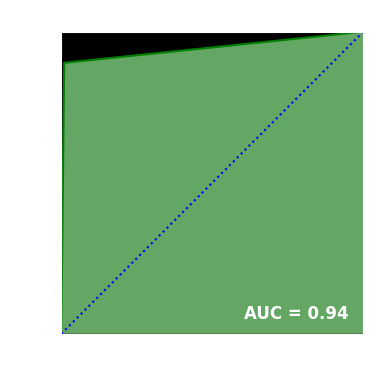

In [35]:
best_par_grad, score_grad = build_pipeline(params, classifier_grad, rskf=True)

### Algorithm Comparison: Parameters

In [36]:
# Plot out different parameters
compare = [best_par_knn, best_par_svm, best_par_lr, best_par_rf, best_par_ada, best_par_grad ]
headers_comparison = [ 'KNN', 'SVM','Logistic Regression','RandomForest','AdaBoost', 'GradBoost']

In [38]:
compare_df = pd.DataFrame(compare)
compare_df["results"]=headers_comparison
compare_df = compare_df.set_index('results', drop=True).rename_axis(None)
compare_df

,accuracy,precision,recall,fi,auc
KNN,0.947368,0.983607,0.882353,0.930233,0.936322
SVM,0.947368,0.968254,0.897059,0.931298,0.938821
Logistic Regression,0.959064,0.984127,0.911765,0.946565,0.951028
RandomForest,0.953216,0.983871,0.897059,0.938462,0.943675
AdaBoost,0.947368,0.983607,0.882353,0.930233,0.936322
GradBoost,0.953216,0.983871,0.897059,0.938462,0.943675


In [39]:
compare_df.T.iplot(kind='bar', width=0.9)


### Algorithm Comparison: Scores

In [40]:
def get_scores(gs_results):
    """Return hs_results in dictionary"""
    return {
        'Best Score' : gs_results.best_score_,
        'Best parameters': gs_results.best_params_,
        'Means' : gs_results.cv_results_['mean_test_score'],
        'Stds' : gs_results.cv_results_['std_test_score'],
        'Params' : gs_results.cv_results_['params']
        }

In [41]:
# Plot out different parameters
score_objects = [score_knn, score_svm, score_lr, score_rf, score_ada, score_grad ]
compare2 = [ get_scores(x) for x in score_objects  ]

compare_df2 = pd.DataFrame(compare2)
compare_df2["results"]=headers_comparison
compare_df2 = compare_df2.set_index('results', drop=True).rename_axis(None)

In [42]:
compare_df2

,Best Score,Best parameters,Means,Stds,Params
KNN,0.968780,"{'balancing': 'passthrough', 'clf__metric': 'm...","[0.9590519703026843, 0.9590138968208644, 0.959...","[0.017747348215364948, 0.012864330328568638, 0...","[{'balancing': 'passthrough', 'clf__metric': '..."
SVM,0.960937,"{'balancing': 'passthrough', 'clf__degree': 0....","[0.9433466590519703, 0.9609366076527699, 0.943...","[0.0190397294436976, 0.018602568408854308, 0.0...","[{'balancing': 'passthrough', 'clf__degree': 0..."
Logistic Regression,0.970741,"{'balancing': 'passthrough', 'clf__class_weigh...","[0.9687987816485817, 0.9512088330477824, 0.968...","[0.011234322609650963, 0.02135924026775639, 0....","[{'balancing': 'passthrough', 'clf__class_weig..."
RandomForest,0.970721,"{'clf__max_depth': 30, 'clf__min_samples_leaf'...","[0.9550732914525033, 0.9609746811345898, 0.962...","[0.010007786883779452, 0.012221528359559166, 0...","[{'clf__max_depth': 20, 'clf__min_samples_leaf..."
AdaBoost,0.964839,"{'clf__learning_rate': 0.1, 'clf__n_estimators...","[0.9004251538803224, 0.9004251538803224, 0.900...","[0.02270801708774038, 0.02270801708774038, 0.0...","[{'clf__learning_rate': 0.0001, 'clf__n_estima..."
GradBoost,0.968101,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...","[0.666019417475728, 0.8867123548448508, 0.9524...","[0.0031708605084571776, 0.022800744673469507, ...","[{'clf__learning_rate': 0.01, 'clf__max_depth'..."


In [43]:
compare_df2['Best Score'].T.iplot(kind='bar')

In [44]:
import plotly.graph_objects as px
def plot_box(data):
    plot = px.Figure()

    for i,each in enumerate(data.to_list()):
        plot.add_trace(px.Box(y=each, boxmean=True, name=headers_comparison[i]))

    plot.update_layout(template='plotly_dark', title="Algorthm Comparison")
    plot.show()

In [45]:
plot_box(compare_df2['Means'])

In [46]:
plot_box(compare_df2['Stds'])

### Summary

1. Which of these ML algorithms works best with the given breast cancer dataset? The best AUR ROC score is for the RandomForestClassifier algorithm.

2. Are your calculated feature importances in line with the relevant literature or not? The two most relevant features in the RandomForestClassifier
are UCSh/UCSi Ratio (an engineered feature comprised of UCSh/sqrt(UCSi) ) and Bland Chromatin, which correspond to three out of four of the most relevant features in literature.

3. Does the data need some pre-processing before you can run the ML algorithms on it? Are there correlations to be mitigated?
For the chosen algorithm (RandomForestClassifier), the data requires scaling but not balancing. There were two features with
high correlation, as can be seen in the first correlation matrix, but this was fixed with feature engineering.

### References

 [1] Aalaei, Shokoufeh et al. “Feature selection using genetic algorithm for breast cancer diagnosis: experiment on three different datasets.” Iranian journal of basic medical sciences vol. 19,5 (2016): 476-82.
 Last accessed on Jun 27th, 2022 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4923467/)